In [1]:
# expand cells to the 95% of the display width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 95% !important; }</style>"))

# Automatic rule-based modeling of the *Escherichia coli* arabinose-fructose metabolism

Authors: Rodrigo Santibáñez[1,2], Daniel Garrido[2], and Alberto Martín[1]

Date: September 2020

Affiliations:
1. Centro de Genómica y Bioinformática, Facultad de Ciencias, Universidad Mayor, Santiago, 8580745, Chile.
2. Department of Chemical and Bioprocess Engineering, School of Engineering, Pontificia Universidad Católica de Chile, Santiago, 7820436, Chile

Notes: This tutorial was created for the manuscript "*Atlas*: Automatic modeling of regulation of bacterial gene expression and metabolism using rule-based languages", first submitted for peer-review to Bioinformatics on May, 2020.

## Prerequisites

0. The tutorial was prepared and executed on Ubuntu 20.04, PathwayTools version 24, and docker engine version 19.03.8.<br/><br/>

1. PathwayTools must be installed and running to obtain data from the EcoCyc database. Please, run ```pathway-tools -lisp -python-local-only``` before to obtain any data.<br/>
   (Optional) The PathwayTools software could be executed in the background, with help of ```nohup pathway-tools -lisp -python-local-only > /dev/null 2> /dev/null &```.<br/>
   Please follow instructions at http://pathwaytools.org/ to obtain a licensed copy of the software from https://biocyc.org/download-bundle.shtml. However, data could be manually formatted using a text-based editor or a spreadsheet software.
   
   Note: If you ran into the ```pathway-tools/aic-export/pathway-tools/ptools/22.5/exe/aclssl.so: undefined symbol: CRYPTO_set_locking_callback``` error, please follow instructions here: https://github.com/glucksfall/atlas/tree/master/PTools. Instructions will guide you to install a docker image that is able to run pathway tools, but does not include it, so you still need to obtain the software with a valid license.<br/><br/>
   
2. (Highly recommended) Install Docker. Please follow instructions for a supported Operating System https://docs.docker.com/engine/install/:<br/>
   On Ubuntu, install it with ```apt-get install docker.io```.<br/>
   On Win10, install Docker Desktop with WSL2 support https://docs.docker.com/docker-for-windows/wsl/.<br/>
   On MacOS, install Docker Desktop https://docs.docker.com/docker-for-mac/install/.<br/><br/>
   The Docker ```networkbiolab/pleiades```installs the python packages, the jupyter server, and the stochastic simulators.<br/><br/>

3. (Recommended) Jupyter notebook. We recommend the use of Anaconda3 https://www.anaconda.com/products/individual because of the easier installation of the stochastic simulators from https://anaconda.org/alubbock.<br/><br/>

4. (Optional) A stochastic simulator, supported by the pySB python package ([BNG2](https://github.com/RuleWorld/bionetgen), [NFsim](https://github.com/ruleworld/nfsim/tree/9178d44455f6e27a81f398074eeaafb2a1a4b4bd), [KaSim](https://github.com/Kappa-Dev/KappaTools) or [Stochkit](https://github.com/StochSS/StochKit)). pySB requires BNG2 to simulate models with NFsim.<br/><br/>

5. (Optional) Cytoscape to visualize metabolic networks and others.

## Preamble: load *Atlas*

In [2]:
# testing source code
import sys
sys.path.append("../..") # If installed from GitHub and this notebooks is executed from the example/subfolder directory.

import atlas_rbm.atlas as atlas
import atlas_rbm.utils as utils
import atlas_rbm.export as export
import atlas_rbm.simulation as simulation

## Modeling metabolism

In [3]:
utils.read_network('input_networks/network-metabolism-curated.txt')

,GENE OR COMPLEX,ENZYME LOCATION,REACTION,SUBSTRATES,PRODUCTS,FWD_RATE,RVS_RATE
0,araE,inner membrane,TRANS-RXN-10-alpha-af,"PER-PROTON,PER-alpha-L-arabinofuranose","PROTON,alpha-L-arabinofuranose",0.0001,0
1,araE,inner membrane,TRANS-RXN-10-beta-af,"PER-PROTON,PER-beta-L-arabinofuranose","PROTON,beta-L-arabinofuranose",0.0001,0
2,araE,inner membrane,TRANS-RXN-10-alpha-ap,"PER-PROTON,PER-alpha-L-arabinopyranose","PROTON,alpha-L-arabinopyranose",0.0001,0
3,araE,inner membrane,TRANS-RXN-10-beta-ap,"PER-PROTON,PER-beta-L-arabinopyranose","PROTON,beta-L-arabinopyranose",0.0001,0
4,"[araG,araG,araH,araH,araF]","[cytosol,cytosol,inner membrane,inner membrane...",ABC-2-RXN-alpha-ap,"PER-alpha-L-arabinopyranose,WATER,ATP","alpha-L-arabinopyranose,Pi,ADP,PROTON",1.0000,0
5,"[araA,araA,araA,araA,araA,araA]","[cytosol,cytosol,cytosol,cytosol,cytosol,cytosol]",ARABISOM-RXN-alpha-ap,alpha-L-arabinopyranose,L-RIBULOSE,1.0000,0
6,"[araA,araA,araA,araA,araA,araA]","[cytosol,cytosol,cytosol,cytosol,cytosol,cytosol]",ARABISOM-RXN-beta-ap,beta-L-arabinopyranose,L-RIBULOSE,1.0000,0
7,"[araB,araB]","[cytosol,cytosol]",RXN0-5116,"L-RIBULOSE,ATP","PROTON,L-RIBULOSE-5-P,ADP",1.0000,0
8,"[araD,araD,araD,araD]","[cytosol,cytosol,cytosol,cytosol]",RIBULPEPIM-RXN,L-RIBULOSE-5-P,XYLULOSE-5-PHOSPHATE,1.0000,0


In [4]:
%time model1 = atlas.construct_model_from_metabolic_network('input_networks/network-metabolism-curated.txt')

# print(atlas.get_rule(model1, 'ABC_2_RXN_alpha_ap')) # we could get the rule by its name, copy and edit by hand if necessary.

new_rule = "Rule('ABC_2_RXN_alpha_ap', "\
    "prot(name='araG', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=1) % "\
    "prot(name='araG', loc='cyt', dna=None, met=None, prot=None, rna=None, up=1, dw=2) % "\
    "prot(name='araH', loc='imem', dna=None, met=None, prot=None, rna=None, up=2, dw=3) % "\
    "prot(name='araH', loc='imem', dna=None, met=None, prot=None, rna=None, up=3, dw=4) % "\
    "prot(name='araF', loc='per', dna=None, met=5, prot=None, rna=None, up=4, dw=None) % "\
    "met(name='alpha_L_arabinopyranose', loc='per', dna=None, met=None, prot=5, rna=None) + "\
    "met(name='WATER', loc='cyt', dna=None, met=None, prot=None, rna=None) + "\
    "met(name='ATP', loc='cyt', dna=None, met=None, prot=None, rna=None) + None | "\
    "prot(name='araG', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=1) % "\
    "prot(name='araG', loc='cyt', dna=None, met=None, prot=None, rna=None, up=1, dw=2) % "\
    "prot(name='araH', loc='imem', dna=None, met=None, prot=None, rna=None, up=2, dw=3) % "\
    "prot(name='araH', loc='imem', dna=None, met=None, prot=None, rna=None, up=3, dw=4) % "\
    "prot(name='araF', loc='per', dna=None, met=None, prot=None, rna=None, up=4, dw=None) + "\
    "met(name='alpha_L_arabinopyranose', loc='cyt', dna=None, met=None, prot=None, rna=None) + "\
    "met(name='Pi', loc='cyt', dna=None, met=None, prot=None, rna=None) + "\
    "met(name='ADP', loc='cyt', dna=None, met=None, prot=None, rna=None) + "\
    "met(name='PROTON', loc='cyt', dna=None, met=None, prot=None, rna=None), "\
    "fwd_ABC_2_RXN_alpha_ap, rvs_ABC_2_RXN_alpha_ap)"

model1 = atlas.replace_rule(model1, name = 'ABC_2_RXN_alpha_ap', new_rule=new_rule) # to connect arabinose to the ABC2 complex
atlas.get_rule(model1, 'ABC_2_RXN_alpha_ap')

CPU times: user 555 ms, sys: 36.6 ms, total: 591 ms
Wall time: 590 ms


Rule('ABC_2_RXN_alpha_ap', prot(name='araG', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=1) % prot(name='araG', loc='cyt', dna=None, met=None, prot=None, rna=None, up=1, dw=2) % prot(name='araH', loc='imem', dna=None, met=None, prot=None, rna=None, up=2, dw=3) % prot(name='araH', loc='imem', dna=None, met=None, prot=None, rna=None, up=3, dw=4) % prot(name='araF', loc='per', dna=None, met=5, prot=None, rna=None, up=4, dw=None) % met(name='alpha_L_arabinopyranose', loc='per', dna=None, met=None, prot=5, rna=None) + met(name='WATER', loc='cyt', dna=None, met=None, prot=None, rna=None) + met(name='ATP', loc='cyt', dna=None, met=None, prot=None, rna=None) + None | prot(name='araG', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=1) % prot(name='araG', loc='cyt', dna=None, met=None, prot=None, rna=None, up=1, dw=2) % prot(name='araH', loc='imem', dna=None, met=None, prot=None, rna=None, up=2, dw=3) % prot(name='araH', loc='imem', dna=None, met=None, prot=N

In [5]:
import pandas
network = pandas.concat([utils.read_network('input_networks/network-ProtProt.txt'), \
                         utils.read_network('input_networks/network-ProtMet.txt'), \
                         utils.read_network('input_networks/network-TFs+DNA.txt')])
# network.reset_index(drop = True)

In [6]:
%time model2 = atlas.construct_model_from_interaction_network(network)
new_rule = "Rule('PhysicalInteractionRule_18', "\
    "prot(name='araG', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=1) % "\
    "prot(name='araG', loc='cyt', dna=None, met=None, prot=None, rna=None, up=1, dw=2) % "\
    "prot(name='araH', loc='imem', dna=None, met=None, prot=None, rna=None, up=2, dw=3) % "\
    "prot(name='araH', loc='imem', dna=None, met=None, prot=None, rna=None, up=3, dw=None) + "\
    "prot(name='araF', loc='per', dna=None, met=4, prot=None, rna=None, up=None, dw=None) % "\
    "met(name='alpha_L_arabinopyranose', loc='per', dna=None, met=None, prot=4, rna=None) | "\
    "prot(name='araG', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=1) % "\
    "prot(name='araG', loc='cyt', dna=None, met=None, prot=None, rna=None, up=1, dw=2) % "\
    "prot(name='araH', loc='imem', dna=None, met=None, prot=None, rna=None, up=2, dw=3) % "\
    "prot(name='araH', loc='imem', dna=None, met=None, prot=None, rna=None, up=3, dw=4) % "\
    "prot(name='araF', loc='per', dna=None, met=5, prot=None, rna=None, up=4, dw=None) % "\
    "met(name='alpha_L_arabinopyranose', loc='per', dna=None, met=None, prot=5, rna=None), "\
    "fwd_PhysicalInteractionRule_18, rvs_PhysicalInteractionRule_18)"

model2 = atlas.replace_rule(model2, name = 'PhysicalInteractionRule_18', new_rule=new_rule) # to correct numbering of internal links.
atlas.get_rule(model2, 'PhysicalInteractionRule_18')

CPU times: user 979 ms, sys: 4.25 ms, total: 984 ms
Wall time: 983 ms


Rule('PhysicalInteractionRule_18', prot(name='araG', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=1) % prot(name='araG', loc='cyt', dna=None, met=None, prot=None, rna=None, up=1, dw=2) % prot(name='araH', loc='imem', dna=None, met=None, prot=None, rna=None, up=2, dw=3) % prot(name='araH', loc='imem', dna=None, met=None, prot=None, rna=None, up=3, dw=None) + prot(name='araF', loc='per', dna=None, met=4, prot=None, rna=None, up=None, dw=None) % met(name='alpha_L_arabinopyranose', loc='per', dna=None, met=None, prot=4, rna=None) | prot(name='araG', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=1) % prot(name='araG', loc='cyt', dna=None, met=None, prot=None, rna=None, up=1, dw=2) % prot(name='araH', loc='imem', dna=None, met=None, prot=None, rna=None, up=2, dw=3) % prot(name='araH', loc='imem', dna=None, met=None, prot=None, rna=None, up=3, dw=4) % prot(name='araF', loc='per', dna=None, met=5, prot=None, rna=None, up=4, dw=None) % met(name='alpha_L_arab

In [7]:
%time model3 = atlas.construct_model_from_genome_graph('input_networks/network-operon-arq.txt')
model3 = atlas.modify_rules(
    model3, 
    oldString = "prot(name='araH', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=None)",
    newString = "prot(name='araH', loc='imem', dna=None, met=None, prot=None, rna=None, up=None, dw=None)",
    names = ['sr_araH_rbs'])
model3 = atlas.modify_rules(
    model3, 
    oldString = "prot(name='araE', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=None)",
    newString = "prot(name='araE', loc='imem', dna=None, met=None, prot=None, rna=None, up=None, dw=None)",
    names = ['sr_araE_rbs'])

print(atlas.get_rule(model3, 'docking_araB_pro1'))
model3 = atlas.add_regulation(model3, name='docking_araB_pro1', 
                              conditions=['[araC,SMALL-alpha-L-arabinopyranose,BS-araC-56-72,araC,SMALL-alpha-L-arabinopyranose,BS-araC-35-51]'], replace = False)
model3 = simulation.set_parameter(model3, 'fwd_docking_araB_pro1_regulated_by_araC_and_araC_1', 1)
model3 = simulation.set_parameter(model3, 'rsv_docking_araB_pro1_regulated_by_araC_and_araC_1', 1)

model3 = atlas.add_regulation(model3, name='docking_araE_pro1', 
                              conditions=['[araC,SMALL-alpha-L-arabinopyranose,BS-araC-83-99,araC,SMALL-alpha-L-arabinopyranose,BS-araC-62-78]'], replace = False)
model3 = simulation.set_parameter(model3, 'fwd_docking_araE_pro1_regulated_by_araC_and_araC_1', 1)
model3 = simulation.set_parameter(model3, 'rsv_docking_araE_pro1_regulated_by_araC_and_araC_1', 1)

model3 = atlas.add_regulation(model3, name='docking_araF_pro1', 
                              conditions=['[araC,SMALL-alpha-L-arabinopyranose,BS-araC-57-73,araC,SMALL-alpha-L-arabinopyranose,BS-araC-36-52]'], replace = False)
model3 = simulation.set_parameter(model3, 'fwd_docking_araE_pro1_regulated_by_araC_and_araC_1', 1)
model3 = simulation.set_parameter(model3, 'rsv_docking_araE_pro1_regulated_by_araC_and_araC_1', 1)

from pysb import *
from pysb.util import alias_model_components
alias_model_components(model3) # to add rules using the pySB functions, we need to "import" the model into the "namespace".

Rule('araF_translocation', 
     prot(name='araF', loc='cyt', dna=None, met=None, prot=None, rna=None, up=None, dw=None) >> 
     prot(name='araF', loc='per', dna=None, met=None, prot=None, rna=None, up=None, dw=None),
    Parameter('translocation', 1))

atlas.get_rule(model3, 'docking_araB_pro1_regulated_by_araC_and_araC_1')

CPU times: user 856 ms, sys: 15.5 ms, total: 871 ms
Wall time: 868 ms
Rule('docking_araB_pro1', cplx(name='RNAP_CPLX', loc='cyt', dna=None) + dna(name='araB', type='pro1', loc='cyt', prot=None) | cplx(name='RNAP_CPLX', loc='cyt', dna=1) % dna(name='araB', type='pro1', loc='cyt', prot=1), fwd_docking_araB_pro1, rvs_docking_araB_pro1)


Rule('docking_araB_pro1_regulated_by_araC_and_araC_1', prot(name='araC', loc='cyt', dna=None, met=2, up=None, dw=1) % met(name='alpha_L_arabinopyranose', loc='cyt', prot=3) % dna(name='araC_56_72', type='BS', loc='cyt', prot=4, up=WILD, dw=WILD) % prot(name='araC', loc='cyt', dna=4, met=3, up=1, dw=None) % met(name='alpha_L_arabinopyranose', loc='cyt', prot=2) % dna(name='araC_35_51', type='BS', loc='cyt', prot=None, up=WILD, dw=WILD) + cplx(name='RNAP_CPLX', loc='cyt', dna=None) + dna(name='araB', type='pro1', loc='cyt', prot=None) | prot(name='araC', loc='cyt', dna=None, met=2, up=None, dw=1) % met(name='alpha_L_arabinopyranose', loc='cyt', prot=3) % dna(name='araC_56_72', type='BS', loc='cyt', prot=4, up=WILD, dw=WILD) % prot(name='araC', loc='cyt', dna=4, met=3, up=1, dw=None) % met(name='alpha_L_arabinopyranose', loc='cyt', prot=2) % dna(name='araC_35_51', type='BS', loc='cyt', prot=None, up=WILD, dw=WILD) + cplx(name='RNAP_CPLX', loc='cyt', dna=5) % dna(name='araB', type='pro1', 

In [8]:
%time combined = atlas.combine_models([model1, model2, model3])
combined

CPU times: user 3.48 s, sys: 35.5 ms, total: 3.52 s
Wall time: 3.51 s


<Model 'atlas_rbm.atlas' (monomers: 5, rules: 109, parameters: 215, expressions: 0, compartments: 0) at 0x7f0ca2a43dc0>

To simulate, we need to set the initial condition:

In [9]:
# initial condition
# for metabolites
simulation.set_initial.met(combined, 'ATP', 'cyt', 100) # required for arabinose transport and the kinase reaction
simulation.set_initial.met(combined, 'PROTON', 'per', 100) # required for arabinose transport araE
simulation.set_initial.met(combined, 'WATER', 'cyt', 100) # required for ATP hydrolysis
simulation.set_initial.met(combined, 'alpha_L_arabinopyranose', 'per', 100)

# for genes
simulation.set_initial.dna(combined, 'araBaraAaraD', 1)
simulation.set_initial.dna(combined, 'araC', 1)
simulation.set_initial.dna(combined, 'araE', 0)
simulation.set_initial.dna(combined, 'araFaraGaraH', 1)

# proteins
simulation.set_initial.prot(combined, 'araF', 'per', 0) # creates the observable
simulation.set_initial.prot(combined, 'araH', 'imem', 0) # creates the observable

# complex
simulation.set_initial.cplx(combined, 'RNAP_CPLX', 'cyt', 10)
simulation.set_initial.cplx(combined, 'RIBOSOME_CPLX', 'cyt', 10)

Initial t0_met_PROTON_per not found. Creating Initial t0_met_PROTON_per...
Initial t0_met_alpha_L_arabinopyranose_per not found. Creating Initial t0_met_alpha_L_arabinopyranose_per...
Initial t0_prot_araF_per not found. Creating Initial t0_prot_araF_per...
Initial t0_prot_araH_imem not found. Creating Initial t0_prot_araH_imem...
Initial t0_cplx_RNAP_CPLX_cyt not found. Creating Initial t0_cplx_RNAP_CPLX_cyt...
Initial t0_cplx_RIBOSOME_CPLX_cyt not found. Creating Initial t0_cplx_RIBOSOME_CPLX_cyt...


<Model 'atlas_rbm.atlas' (monomers: 5, rules: 109, parameters: 221, expressions: 0, compartments: 0) at 0x7f0ca2a43dc0>

In [10]:
# simulation
bng = '/opt/git-repositories/bionetgen.RuleWorld/bng2/'
kasim = '/opt/git-repositories/KaSim4.Kappa-Dev/'

# %time data1 = simulation.scipy(combined, start = 0, finish = 10, points = 500)
%time data2 = simulation.kasim(combined, start = 0, finish = 1000, points = 1000, n_runs = 100, path = kasim)

CPU times: user 5.92 s, sys: 943 ms, total: 6.86 s
Wall time: 3min 59s


Finally, we plot the simulation results. The result of the ```simulation.ode()``` function is a pandas dataframe. In the case of stochastic simulations (SSA, KaSim, NFsim, Stochkit), the function returns a dictionary with a list of dataframe for each simulations (```sims``` key), and dataframe with the average (```avrg``` key) and a dataframe with the standard deviation (```stdv``` key) of those simulations. Currently, we included three kind of plots, although the user could access the dataframes and plot diretly with methods in the seaborn package (https://seaborn.pydata.org/), in the pandas package (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html), or with matplotlib (https://matplotlib.org/).

In [11]:
import seaborn
import matplotlib.pyplot as plt

for key in [
#     'figure.titlesize',
    'font.size',
#     'legend.fontsize',
#     'legend.title_fontsize',
    'font.size', 
#     'xtick.labelsize',
    'xtick.major.size',
    'xtick.minor.size',
#     'ytick.labelsize',
    'ytick.major.size',
    'ytick.minor.size']:
    plt.rcParams[key] = plt.rcParams[key] * 1.1

palette = seaborn.color_palette('colorblind')

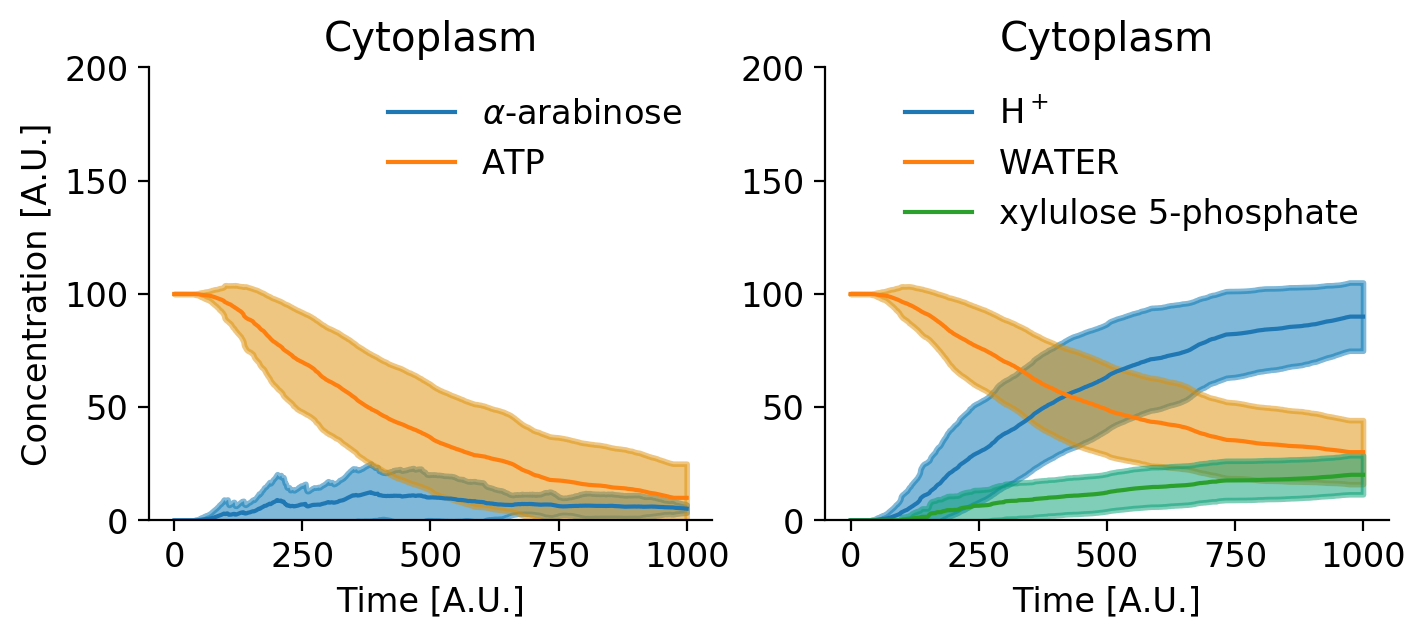

In [12]:
kind = 'fill_between'
fig, ax = plt.subplots(1, 2, figsize = (4*2, 3*1), dpi = 200)

# first plot, arabinose, ATP concentration
simulation.plot.metabolite(data2['avrg'], 'alpha_L_arabinopyranose', 'cyt', ax = ax[0], plt_kws = {'label' : r'$\alpha$-arabinose'})
simulation.plot.metabolite(data2['avrg'], 'ATP', 'cyt', ax = ax[0], plt_kws = {'label' : r'ATP'})

simulation.plot.metabolite(
    data2, 'alpha_L_arabinopyranose', 'cyt', ax = ax[0], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[0], 'alpha' : .5})
simulation.plot.metabolite(
    data2, 'ATP', 'cyt', ax = ax[0], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[1], 'alpha' : .5})

# second plot, protons, water, xylulose5P concentration
simulation.plot.metabolite(data2['avrg'], 'PROTON', 'cyt', ax = ax[1], plt_kws = {'label' : r'H$^+$'})
simulation.plot.metabolite(data2['avrg'], 'WATER', 'cyt', ax = ax[1], plt_kws = {'label' : r'WATER'})
simulation.plot.metabolite(data2['avrg'], 'XYLULOSE-5-PHOSPHATE', 'cyt', ax = ax[1], plt_kws = {'label' : r'xylulose 5-phosphate'})

simulation.plot.metabolite(
    data2, 'PROTON', 'cyt', ax = ax[1], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[0], 'alpha' : .5})
simulation.plot.metabolite(
    data2, 'WATER', 'cyt', ax = ax[1], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[1], 'alpha' : .5})
simulation.plot.metabolite(
    data2, 'XYLULOSE-5-PHOSPHATE', 'cyt', ax = ax[1], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[2], 'alpha' : .5})

ax[0].set_xlabel('Time [A.U.]')
ax[0].set_ylabel('Concentration [A.U.]')
ax[0].set_title('Cytoplasm')
ax[0].set_ylim(top = 200, bottom = 0)

ax[1].set_xlabel('Time [A.U.]')
ax[1].set_title('Cytoplasm')
ax[1].set_ylim(top = 200, bottom = 0)

ax[0].legend(frameon = False)
ax[1].legend(frameon = False)

seaborn.despine()
plt.savefig('figure_1C.pdf', format = 'pdf', bbox_inches = 'tight', dpi = 300)
plt.savefig('figure_1C.png', format = 'png', bbox_inches = 'tight', dpi = 300)
plt.savefig('figure_1C.jpg', format = 'jpg', bbox_inches = 'tight', dpi = 300)

plt.show()